# Random feature for Softmax Kernel
우선, 정규화를 빼고 생각해보자.  
이는 곧 $k_{\mathrm{SM}}(\mathbf{x}, \mathbf{y}) = \exp(\mathbf{x}^\top\mathbf{y})$로 정의될 수 있다.  
여기서 우리는 $\|\mathbf{x}-\mathbf{y}\|^2=(\mathbf{x}-\mathbf{y})^\top(\mathbf{x}-\mathbf{y})=\mathbf{x}^\top\mathbf{x}-2\mathbf{x}^\top\mathbf{y}+\mathbf{y}^\top\mathbf{y}=\|\mathbf{x}\|^2-2\mathbf{x}^\top\mathbf{y}+\|\mathbf{y}\|^2$를 이용해 위 식을 분해할 수 있다.
$$k_{\mathrm{SM}}(\mathbf{x}, \mathbf{y})=\exp(\mathbf{x}^\top\mathbf{y})=\exp(\frac{\|\mathbf{x}\|^2}{2} - \frac{\|\mathbf{x}-\mathbf{y}\|^2}{2} + \frac{\|\mathbf{y}\|^2}{2})=\exp(\frac{\|\mathbf{x}\|^2}{2})\exp(- \frac{\|\mathbf{x}-\mathbf{y}\|^2}{2})\exp(\frac{\|\mathbf{y}\|^2}{2}) =\exp(\frac{\|\mathbf{x}\|^2}{2})k_\mathrm{gauss}(\mathbf{x},\mathbf{y})\exp(\frac{\|\mathbf{y}\|^2}{2})  $$

[[3.93136049 1.07312826 1.04108453 0.96053679]
 [1.07312826 3.2882934  1.026229   0.97444137]
 [1.04108453 1.026229   3.47937662 0.28740781]
 [0.96053679 0.97444137 0.28740781 3.47937662]]


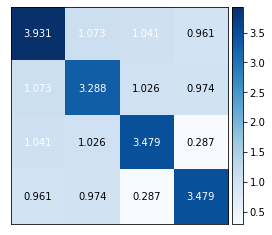

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
np.random.seed(2)

# d차원 공간 상의 n개의 점을 랜덤하게 생성한다.
n, d = 4, 512
x = np.random.randn(n-1, d) / 20
x = np.concatenate((x, -x[[-1]]), axis=0)

# 모든 벡터 페어의 소프트맥스 커널 값을 계산한다.
kernel = np.exp(np.einsum("ij,kj->ik", x, x))
print(kernel)

# 시각화
fig, ax = plt.subplots()
ax.set_xticks([])
ax.set_yticks([])
im = ax.imshow(kernel, cmap=plt.get_cmap("Blues"))
median = np.median(kernel)
for j in range(kernel.shape[0]):
    for i in range(kernel.shape[1]):
        ax.text(j, i, f"{kernel[j, i]:.3f}", ha="center", va="center", c="w" if kernel[j, i] > median else "k")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

즉, 그냥 가우시안 커널을 근사한 다음 적절한 스케일링을 통해 소프트맥스 커널을 근사할 수 있음을 의미한다.
$$\mathbf{z}_3(\mathbf{x}) = \frac{\exp(\frac{\|\mathbf{x}\|^2}{2})}{\sqrt{m}} [ \cos(\mathbf{w}_1^\top\mathbf{x}), \sin (\mathbf{w}_1^\top \mathbf{x}), ..., \cos(\mathbf{w}_m^\top\mathbf{x}), \sin (\mathbf{w}_m^\top \mathbf{x}) ] \text{ such that } \mathbf{w}_1, ..., \mathbf{w}_m \sim \mathcal{N}(\mathbf{0},\mathbf{I}_d)$$

error mean: 0.147, variance: 0.002


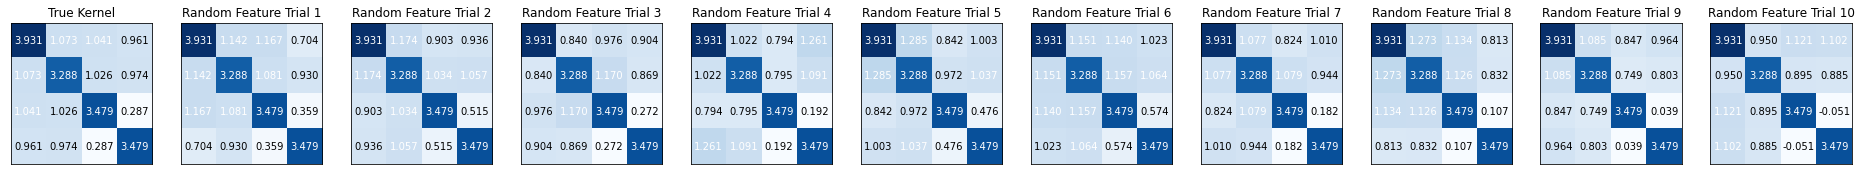

In [61]:
m = 256
kernel_rf_list = []
error_list = []
for _ in range(10):
    w = np.random.multivariate_normal(mean=np.zeros(d), cov=np.eye(d), size=(m,))
    wx = np.einsum("nd,md->nm", x, w)
    z = np.concatenate((np.cos(wx), np.sin(wx)), axis=1)
    z = np.exp(np.einsum("nm,nm->n", x, x) / 2)[:, None] * z / np.sqrt(m)
    kernel_rf = np.einsum("nm,om->no", z, z)
    kernel_rf_list.append(kernel_rf)
    error = np.mean(np.abs((kernel - kernel_rf)/kernel))
    error_list.append(error)
print(f"error mean: {np.mean(error_list):.3f}, variance: {np.var(error_list):.3f}")

# 시각화
median = np.median(kernel)

fig, axes = plt.subplots(1, 11, figsize=(33, 3), facecolor="w")
for idx in range(11):
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

axes[0].set_title("True Kernel")
im = axes[0].imshow(kernel, cmap=plt.get_cmap("Blues"), vmin=np.min(kernel), vmax=np.max(kernel))
for j in range(kernel.shape[0]):
    for i in range(kernel.shape[1]):
        axes[0].text(j, i, f"{kernel[j, i]:.3f}", ha="center", va="center", c="w" if kernel[j, i] > median else "k")
for idx in range(1, 11):
    axes[idx].set_title(f"Random Feature Trial {idx}")
    im = axes[idx].imshow(kernel_rf_list[idx-1], cmap=plt.get_cmap("Blues"), vmin=np.min(kernel), vmax=np.max(kernel))
    for j in range(kernel_rf_list[idx-1].shape[0]):
        for i in range(kernel_rf_list[idx-1].shape[1]):
            axes[idx].text(j, i, f"{kernel_rf_list[idx-1][j, i]:.3f}", ha="center", va="center", c="w" if kernel_rf_list[idx-1][j, i] > median else "k")
plt.show()

근데 이는 크리티컬 리전에서 잘 죽는다고 한다.  
그래서 positive random feature를 이용하는 방법이 있다고 한다.
$$\mathbf{z}_4(\mathbf{x}) = \frac{\exp(\frac{\|\mathbf{x}\|^2}{2})}{\sqrt{2m}} [ \exp(\mathbf{w}_1^\top\mathbf{x}), \exp (-\mathbf{w}_1^\top \mathbf{x}), ..., \exp(\mathbf{w}_m^\top\mathbf{x}), \exp (-\mathbf{w}_m^\top \mathbf{x}) ] \text{ such that } \mathbf{w}_1, ..., \mathbf{w}_m \sim \mathcal{N}(\mathbf{0},\mathbf{I}_d)$$

error mean: 0.115, variance: 0.002


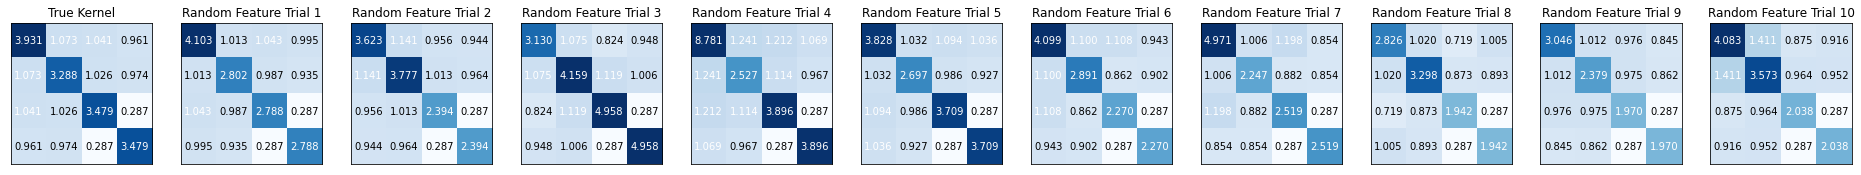

In [62]:
m = 256
kernel_rf_list = []
error_list = []
for _ in range(10):
    w = np.random.multivariate_normal(mean=np.zeros(d), cov=np.eye(d), size=(m,))
    wx = np.einsum("nd,kd->nk", x, w)
    z = np.concatenate((np.exp(wx), np.exp(-wx)), axis=1)
    h = np.exp(-np.einsum("id,id->i", x, x) / 2) / np.sqrt(2)
    z = h[:, None] * z
    z = z / np.sqrt(m)
    kernel_rf = np.einsum("nk,mk->nm", z, z)
    kernel_rf_list.append(kernel_rf)
    error = np.mean(np.abs((kernel - kernel_rf)/kernel))
    error_list.append(error)
print(f"error mean: {np.mean(error_list):.3f}, variance: {np.var(error_list):.3f}")

# 시각화
median = np.median(kernel)

fig, axes = plt.subplots(1, 11, figsize=(33, 3), facecolor="w")
for idx in range(11):
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

axes[0].set_title("True Kernel")
im = axes[0].imshow(kernel, cmap=plt.get_cmap("Blues"), vmin=np.min(kernel), vmax=np.max(kernel))
for j in range(kernel.shape[0]):
    for i in range(kernel.shape[1]):
        axes[0].text(j, i, f"{kernel[j, i]:.3f}", ha="center", va="center", c="w" if kernel[j, i] > median else "k")
for idx in range(1, 11):
    axes[idx].set_title(f"Random Feature Trial {idx}")
    im = axes[idx].imshow(kernel_rf_list[idx-1], cmap=plt.get_cmap("Blues"), vmin=np.min(kernel), vmax=np.max(kernel))
    for j in range(kernel_rf_list[idx-1].shape[0]):
        for i in range(kernel_rf_list[idx-1].shape[1]):
            axes[idx].text(j, i, f"{kernel_rf_list[idx-1][j, i]:.3f}", ha="center", va="center", c="w" if kernel_rf_list[idx-1][j, i] > median else "k")
plt.show()

또한 랜덤 피쳐를 직교화하면 더 잘 된다고 한다.

error mean: 0.094, variance: 0.001


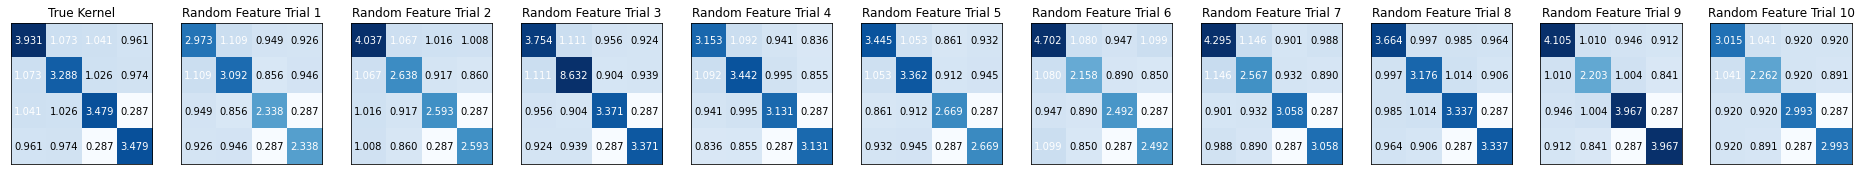

In [63]:
m = 256
kernel_rf_list = []
error_list = []
for _ in range(10):
    w = np.random.multivariate_normal(mean=np.zeros(d), cov=np.eye(d), size=(m,))
    w_org, _ = np.linalg.qr(w)
    tmp = np.ceil(w.shape[1]/w_org.shape[1]).astype(np.int32)
    w_org = np.concatenate([w_org for _ in range(tmp)], axis=1)[:, :w.shape[1]]
    w_org = w_org / np.linalg.norm(w_org, axis=1, keepdims=True)
    w = w_org * np.linalg.norm(w, axis=1, keepdims=True)
    wx = np.einsum("nd,kd->nk", x, w)
    z = np.concatenate((np.exp(wx), np.exp(-wx)), axis=1)
    h = np.exp(-np.einsum("id,id->i", x, x) / 2) / np.sqrt(2)
    z = h[:, None] * z
    z = z / np.sqrt(m)
    kernel_rf = np.einsum("nk,mk->nm", z, z)
    kernel_rf_list.append(kernel_rf)
    error = np.mean(np.abs((kernel - kernel_rf)/kernel))
    error_list.append(error)
print(f"error mean: {np.mean(error_list):.3f}, variance: {np.var(error_list):.3f}")

# 시각화
median = np.median(kernel)

fig, axes = plt.subplots(1, 11, figsize=(33, 3), facecolor="w")
for idx in range(11):
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

axes[0].set_title("True Kernel")
im = axes[0].imshow(kernel, cmap=plt.get_cmap("Blues"), vmin=np.min(kernel), vmax=np.max(kernel))
for j in range(kernel.shape[0]):
    for i in range(kernel.shape[1]):
        axes[0].text(j, i, f"{kernel[j, i]:.3f}", ha="center", va="center", c="w" if kernel[j, i] > median else "k")
for idx in range(1, 11):
    axes[idx].set_title(f"Random Feature Trial {idx}")
    im = axes[idx].imshow(kernel_rf_list[idx-1], cmap=plt.get_cmap("Blues"), vmin=np.min(kernel), vmax=np.max(kernel))
    for j in range(kernel_rf_list[idx-1].shape[0]):
        for i in range(kernel_rf_list[idx-1].shape[1]):
            axes[idx].text(j, i, f"{kernel_rf_list[idx-1][j, i]:.3f}", ha="center", va="center", c="w" if kernel_rf_list[idx-1][j, i] > median else "k")
plt.show()